Following the tutorial from DataQuest https://www.dataquest.io/blog/climate-temperature-spirals-python/

But using data from /r/dataisbeautiful https://www.reddit.com/r/dataisbeautiful/comments/a9b5kj/160_years_of_lake_mendota_ice_cover_oc/

In [1]:
import pandas as pd

### loading tutorial data to confirm expected format

In [2]:
#load sample data for reference
hadcrut = pd.read_csv(
    'HadCRUT.4.6.0.0.monthly_ns_avg.txt'
    ,delim_whitespace = True
    ,usecols=[0,1]
    ,header=None
)

hadcrut.head()

,0,1
0,1850/01,-0.700
1,1850/02,-0.286
2,1850/03,-0.732
3,1850/04,-0.563
4,1850/05,-0.327


In [3]:
#clean up sample data
hadcrut['year'] = hadcrut[0].apply(lambda x: int(x.split('/')[0]))
hadcrut['month'] = hadcrut[0].apply(lambda x: int(x.split('/')[1]))
hadcrut['value'] = hadcrut[1]

hadcrut = hadcrut[['year', 'month', 'value']]

hadcrut.head()

,year,month,value
0,1850,1,-0.700
1,1850,2,-0.286
2,1850,3,-0.732
3,1850,4,-0.563
4,1850,5,-0.327


### load Mendota data

In [127]:
from bs4 import BeautifulSoup
import urllib
import re
import numpy as np

In [128]:
#load raw data from site
source_site = 'http://www.aos.wisc.edu/~sco/lakes/Mendota-ice.html'
file = urllib.request.urlopen(source_site)
soup = BeautifulSoup(file, 'lxml')#.get_text(strip=True)

In [129]:
#what kind of sick monster stores data this way?!
#loop through the cells and store data first as lists, then in a dataframe

#initialize lists
years = []
ice_ons = []
ice_offs = []
days_ice = []

#sections are stored as single cells with linebreaks
for row in soup.find_all('tr'):
    #each row has 8 cells, 4+4, for the values
    i=0
    for cell in row.find_all('td'):
        cell_values = cell.get_text()
        
        #error in one set of years
        if '2004' in cell_values:
            cell_values = cell_values.replace('2005-06', '\n2005-06\n')
            
        if '2010' in cell_values:
            cell_values = cell_values.replace('2012-13', '\n2012-13\n')
            cell_values = cell_values.replace('2015-16', '\n2015-16\n')
            cell_values = cell_values.replace('2017-18', '\n2017-18\n')
        
        #some weird elements sneak in
        cell_values = cell_values.replace('\xa0', '\n')
        cell_values = re.sub('(?<=[a-z])(?=( |[0-9]))', '\n', cell_values)
        
        cell_values = cell_values.split('\n')
        
        #cut empty strings
        cell_values = [cv.strip() for cv in cell_values if cv.strip() != '']
        
        if i == 0:
            years.extend(cell_values)
        elif i == 1:
            ice_ons.extend(cell_values)
        elif i == 2:
            ice_offs.extend(cell_values)
        elif i == 3:
            days_ice.extend(cell_values)
            
        #reset for the second round
        i = 0 if i == 4 else i + 1

        
#take the first part of the year, or a signal that the previous year has another row
years = [y.split('-')[0] if y != '\"' else 'ditto' for y in years]

In [130]:
#load into a sensible format

df = pd.DataFrame(data={
    'winter_starting': years
    ,'ice_on': ice_ons
    ,'ice_off': ice_offs
    ,'days_ice': days_ice
})

df.head()

,winter_starting,ice_on,ice_off,days_ice
0,1852,---,5 Apr,---
1,1853,27 Dec,---,---
2,1854,---,---,---
3,1855,18 Dec,14 Apr,118
4,1856,6 Dec,6 May,151


In [131]:
#remove rows where ice on/off is '---'
df = df.replace('---', np.nan)
df = df.dropna(how='any')

#loop through years with multiple rows and set the year correctly
for i,r in df[df['winter_starting'] == 'ditto'].iterrows():
    df['winter_starting'][i] = df['winter_starting'][i-1]
    
df.head()

,winter_starting,ice_on,ice_off,days_ice
3,1855,18 Dec,14 Apr,118
4,1856,6 Dec,6 May,151
5,1857,25 Nov,26 Mar,121
6,1858,8 Dec,14 Mar,96
7,1859,7 Dec,26 Mar,110


In [132]:
#convert dates to year fractions
from datetime import datetime

def str_date_to_frac(date_string):
    date = datetime.strptime(date_string, '%d %b')
    year_fraction = date.timetuple().tm_yday
    year_fraction = year_fraction * 1.0 / 366
    return year_fraction

df['ice_on_frac'] = df['ice_on'].apply(str_date_to_frac)
df['ice_off_frac'] = df['ice_off'].apply(str_date_to_frac)


#rebase to the start of the season (Nov 23)
start_of_season = df[df['ice_on_frac'] > 0.5]['ice_on_frac'].min()
def adjust_to_season(val):
    if val > 0.5:
        adjusted_val = val - start_of_season
    else:
        adjusted_val = (val + 1) - start_of_season
        
    return adjusted_val

df['ice_on_frac'] = df['ice_on_frac'].apply(adjust_to_season)
df['ice_off_frac'] = df['ice_off_frac'].apply(adjust_to_season)

#loop through years with missing days on ice, and calculate


df.head()

,winter_starting,ice_on,ice_off,days_ice,ice_on_frac,ice_off_frac
3,1855,18 Dec,14 Apr,118,0.068306,0.390710
4,1856,6 Dec,6 May,151,0.035519,0.450820
5,1857,25 Nov,26 Mar,121,0.005464,0.338798
6,1858,8 Dec,14 Mar,96,0.040984,0.306011
7,1859,7 Dec,26 Mar,110,0.038251,0.338798


## plot

In [133]:
import matplotlib.pyplot as plt
%matplotlib inline

In [134]:
#given a single row, pull the values necessary for plotting
def plot_year(row_y):
    #df_2000 = df.loc[153]

    #print(row_y['days_ice'], '-' in row_y['days_ice'])
    r = int(row_y['winter_starting']) - 1850
    
    #some rows have missing days
    if '-' in row_y['days_ice']:
        days = round(366 * (row_y['ice_off_frac'] - row_y['ice_on_frac'])) + 1
    else:
        days = int(row_y['days_ice'])
    
    r = [r] * days

    theta = np.linspace(row_y['ice_on_frac'] * 2 * np.pi
                   ,row_y['ice_off_frac'] * 2 * np.pi
                   ,days)
    
    return theta, r, days



### Stable image

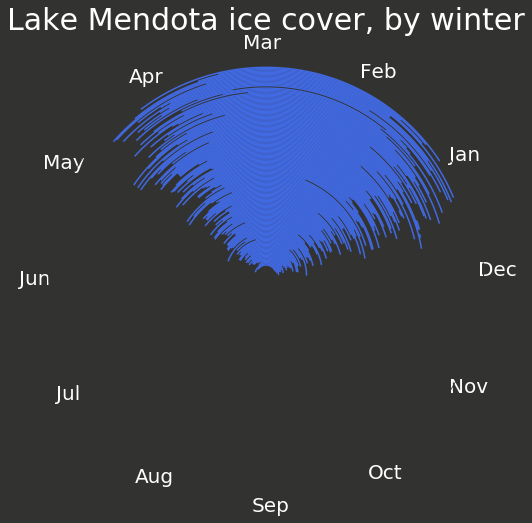

In [156]:
fig = plt.figure(figsize=(8,8))
ax1 = plt.subplot(111, projection='polar')


#formatting

fig.set_facecolor('#323331')
ax1.set_facecolor('#323331')


ax1.set_title('Lake Mendota ice cover, by winter'
             ,color='white'
             ,fontdict={'fontsize': '30'})

#ax1.text(0,0, '2000-01'
#        ,color='white'
#        ,size=30
#        ,ha='center')

#show months
month_names = ['Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']
start = 7.0 / 366 #Dec 1 is 7 days past the start of season
incr = [start + i * 2 * np.pi / 12 for i in range(12)]

ax1.set_xticks(incr)
ax1.set_xticklabels(month_names, color='white', size=20)
ax1.tick_params(axis='both', grid_linewidth=0)
ax1.spines['polar'].set_color('#323331')

ax1.axes.get_yaxis().set_ticklabels([])


#data

for i,r in df.iterrows():
    theta, rads, days = plot_year(r)
    ax1.plot(theta, rads, c= '#4169e1') #plt.cm.viridis(days))
             #color='#4169e1')


#plt.colorbar(ax=ax1)
plt.show()



### GIF

MovieWriter imagemagick unavailable.


TypeError: 'numpy.float64' object cannot be interpreted as an integer

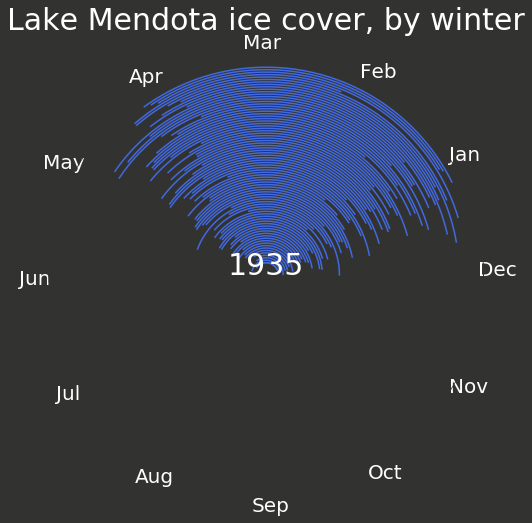

In [171]:
import sys
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(8,8))
ax1 = plt.subplot(111, projection='polar')

fig.set_facecolor('#323331')
ax1.set_facecolor('#323331')


ax1.set_title('Lake Mendota ice cover, by winter'
             ,color='white'
             ,fontdict={'fontsize': '30'})

#show months
month_names = ['Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']
start = 7.0 / 366 #Dec 1 is 7 days past the start of season
incr = [start + i * 2 * np.pi / 12 for i in range(12)]

ax1.set_xticks(incr)
ax1.set_xticklabels(month_names, color='white', size=20)
ax1.tick_params(axis='both', grid_linewidth=0)
ax1.spines['polar'].set_color('#323331')

ax1.axes.get_yaxis().set_ticklabels([])



year_text = [None]
def update(i):
    year = df.iloc[i]
    theta, rads, days = plot_year(year)
    ax1.plot(theta, rads, c= '#4169e1')
    
    if year_text[0]:
        year_text[0].remove()
    year_text[0] = ax1.text(0,0, year['winter_starting']
        ,color='white'
        ,size=30
        ,ha='center')
    
    return ax1

anim = FuncAnimation(fig, update, frames=df.shape[0], repeat=False, blit=False)

anim.save('mendota_spiral.gif', dpi=120, writer='imagemagick', savefig_kwargs={'facecolor':'#323331'})
    